# ME 5920 FINAL PROJECT - SCIENTIFIC SIMULATIONS GROUP 1



## Group Members



1.   George Ayobami Thomas
2.   Mridul Bhattarai
3.   Hossein Asgaribakhtiari




## 1.1. Setup and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Mounted at /content/drive


## 1.2. Load data from Google Drive (dataset 1)


In [2]:
DATA_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TRAIN_FD004.xlsx'
df = pd.read_excel(DATA_PATH)

# Inspect
print(df.head())

   Engine_ID  Cy_F     OP_1    OP_2  OP_3     S_1     S_2      S_3      S_4  \
0          1     1  42.0049  0.8400   100  445.00  549.68  1343.43  1112.93   
1          1     2  20.0020  0.7002   100  491.19  606.07  1477.61  1237.50   
2          1     3  42.0038  0.8409   100  445.00  548.95  1343.12  1117.05   
3          1     4  42.0000  0.8400   100  445.00  548.70  1341.24  1118.03   
4          1     5  25.0063  0.6207    60  462.54  536.10  1255.23  1033.59   

    S_5  ...     S_14     S_15  S_16  S_17  S_18    S_19   S_20     S_21  \
0  3.91  ...  8074.83   9.3335  0.02   330  2212  100.00  10.62   6.3670   
1  9.35  ...  8046.13   9.1913  0.02   361  2324  100.00  24.37  14.6552   
2  3.91  ...  8066.62   9.4007  0.02   329  2212  100.00  10.48   6.4213   
3  3.91  ...  8076.05   9.3369  0.02   328  2212  100.00  10.54   6.4176   
4  7.05  ...  7865.80  10.8366  0.02   305  1915   84.93  14.03   8.6754   

   Unnamed: 26  RUL  
0          NaN  320  
1          NaN  319  
2 

## 1.3. Preprocessing and dataset definition

In [3]:
FEATURE_COLS = ['OP_1', 'OP_2', 'OP_3'] + [f'S_{i}' for i in range(1, 22)]
TARGET_COL = 'RUL'
ID_COL = 'Engine_ID'
CYCLE_COL = 'Cy_F'

print(df[ID_COL].shape)

'''# Normalize features per column
scaler = StandardScaler()
df[FEATURE_COLS] = scaler.fit_transform(df.loc[:, FEATURE_COLS])
# df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])'''

# Split engines into train/val
engine_ids = df[ID_COL].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.1, random_state=25)

(61249,)


## 1.4. Feature selection using correlation

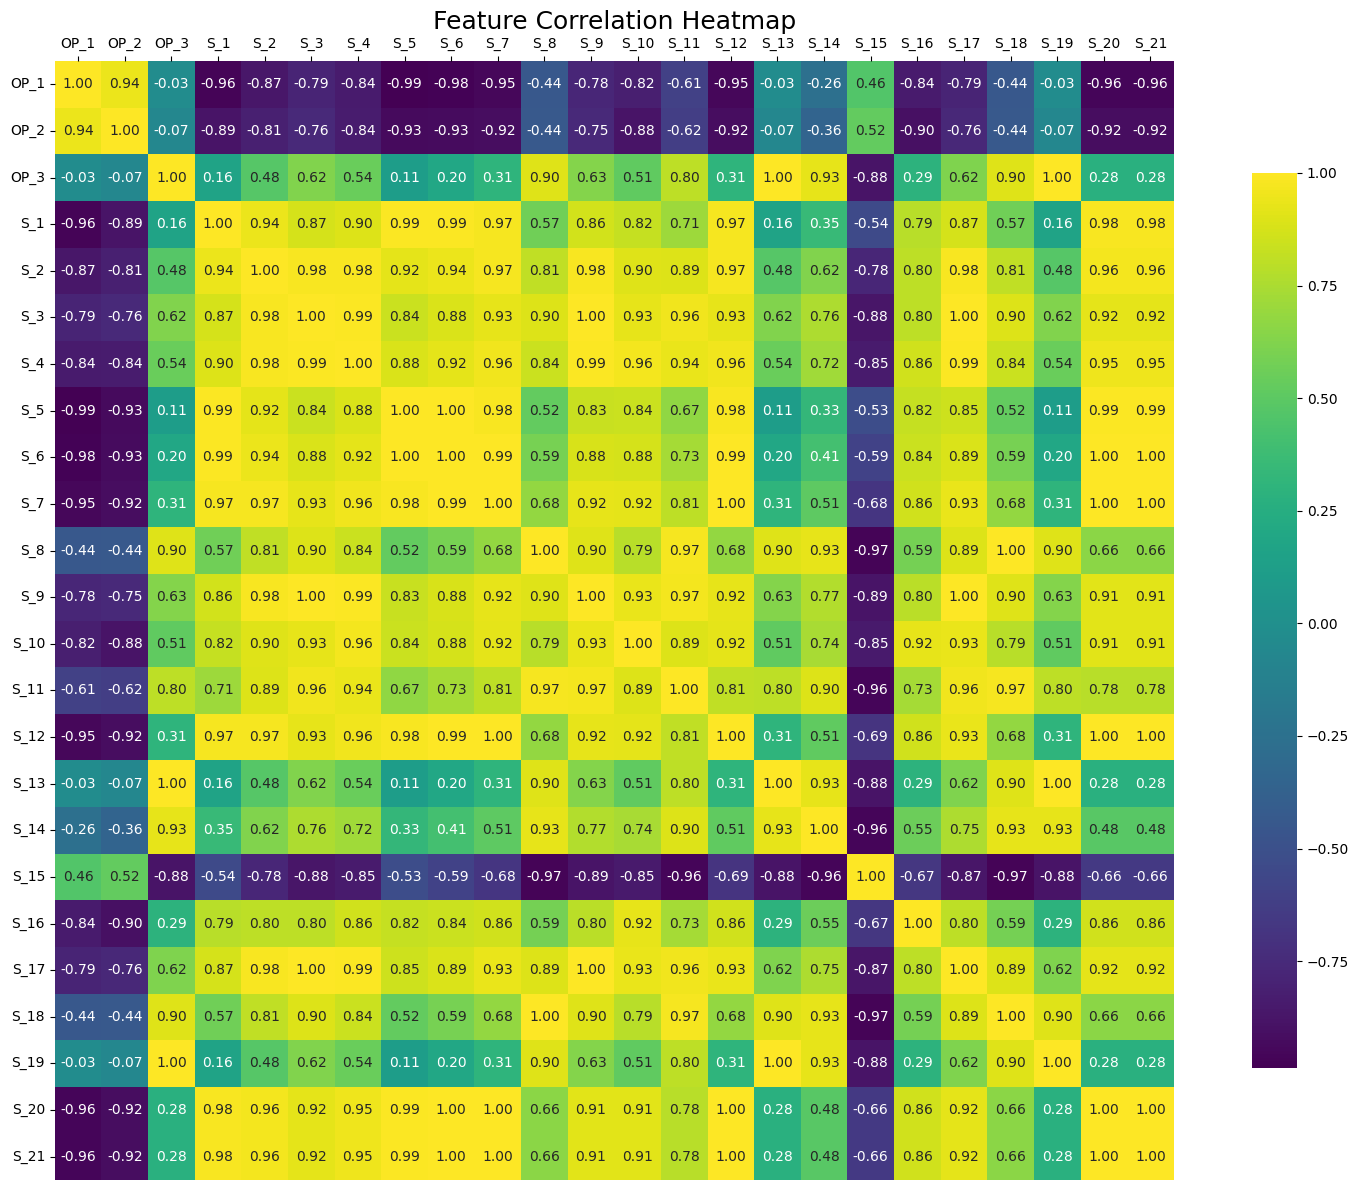

Removing 'S_1' due to high correlation (-0.965) with 'OP_1'
Removing 'S_3' due to high correlation (0.982) with 'S_2'
Removing 'S_4' due to high correlation (0.981) with 'S_2'
Removing 'S_5' due to high correlation (-0.987) with 'OP_1'
Removing 'S_6' due to high correlation (-0.977) with 'OP_1'
Removing 'S_7' due to high correlation (-0.952) with 'OP_1'
Removing 'S_9' due to high correlation (0.978) with 'S_2'
Removing 'S_10' due to high correlation (0.961) with 'S_4'
Removing 'S_11' due to high correlation (0.961) with 'S_3'
Removing 'S_12' due to high correlation (-0.951) with 'OP_1'
Removing 'S_13' due to high correlation (1.000) with 'OP_3'
Removing 'S_15' due to high correlation (-0.969) with 'S_8'
Removing 'S_17' due to high correlation (0.983) with 'S_2'
Removing 'S_18' due to high correlation (1.000) with 'S_8'
Removing 'S_19' due to high correlation (1.000) with 'OP_3'
Removing 'S_20' due to high correlation (-0.962) with 'OP_1'
Removing 'S_21' due to high correlation (-0.962)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train = df.loc[df[ID_COL].isin(train_ids), FEATURE_COLS]

# Compute correlation for alll the combination of two features
corr_matrix = X_train.corr()

# Plot
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, cbar_kws={"shrink": .8})

# Title and ticks formatting
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.xaxis.set_ticks_position('top')# Move x-axis ticks to the top
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.show()

# Set to hold columns to drop
col_corr = set()

threshold = 0.95

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]

            if colname_i not in col_corr:
                print(f"Removing '{colname_i}' due to high correlation ({corr_matrix.iloc[i, j]:.3f}) with '{colname_j}'")
                col_corr.add(colname_i)
# New feature
New_Feature_Cols = [col for col in FEATURE_COLS if col not in col_corr]
print ("New Feature cols:","\n=================\n",New_Feature_Cols)

## 1.5. Drop the columns in 'train_corr' before applying scaling

In [5]:
df_raw = df.copy() #dataframe with all the features
df_corr = df.copy() #dataframe with reduced featres
df_corr = df_corr.drop(columns=col_corr)

#Normalize features per column
scaler_raw=StandardScaler()
scaler_corr=StandardScaler()

df_raw[FEATURE_COLS]=scaler_raw.fit_transform(df_raw.loc[:,FEATURE_COLS])
df_corr[New_Feature_Cols] = scaler_corr.fit_transform(df_corr.loc[:, New_Feature_Cols])

from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler = StandardScaler()
train_ruls = df.loc[df[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1,1)
rul_scaler.fit(train_ruls)

# New column 'RUL_s' for the scaled targets
df_raw['RUL_s'] = df_raw[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

df_corr['RUL_s'] = df_corr[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

# Scale val targets (so loss is computed on same scale)
val_ruls_raw = df_raw.loc[df_raw[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_raw)

val_ruls_corr = df_corr.loc[df_corr[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_corr)
# Update target column name
TARGET_COL_S = 'RUL_s'


def make_sequences(Feature_Cols, df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[Feature_Cols].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

WINDOW_SIZE = 1

train_seqs_raw = make_sequences(FEATURE_COLS, df_raw, train_ids, WINDOW_SIZE)
val_seqs_raw   = make_sequences(FEATURE_COLS, df_raw, val_ids, WINDOW_SIZE)

train_seqs_corr = make_sequences(New_Feature_Cols, df_corr, train_ids, WINDOW_SIZE)
val_seqs_corr  = make_sequences(New_Feature_Cols, df_corr, val_ids, WINDOW_SIZE)

class SequenceDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        x, y = self.seqs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_ds_raw = SequenceDataset(train_seqs_raw)
val_ds_raw   = SequenceDataset(val_seqs_raw)

train_loader_raw = DataLoader(train_ds_raw, batch_size=64, shuffle=False)
val_loader_raw   = DataLoader(val_ds_raw, batch_size=64)


train_ds_corr = SequenceDataset(train_seqs_corr)
val_ds_corr  = SequenceDataset(val_seqs_corr)

train_loader_corr = DataLoader(train_ds_corr, batch_size=64, shuffle=False)
val_loader_corr   = DataLoader(val_ds_corr, batch_size=64)

## 2.1. Long Short-Term Memory (LSTM) model definition

In [6]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last).squeeze()

## 2.2. Transformer model definition

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_enc  = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out      = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        last = x[:, -1, :]
        return self.fc_out(last).squeeze()

## 2.3. Fully Connected Neural Network (FCNN) definition

In [8]:
class FCRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

## 2.3.1. Flattened dataset for FCNN

In [9]:
class FlattenedDataset(Dataset):
    def __init__(self, seqs):
        self.x = [torch.tensor(s[0].flatten(), dtype=torch.float32) for s in seqs]
        self.y = [torch.tensor(s[1], dtype=torch.float32) for s in seqs]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

flat_train_ds_raw = FlattenedDataset(train_seqs_raw)
flat_val_ds_raw   = FlattenedDataset(val_seqs_raw)

flat_train_loader_raw = DataLoader(flat_train_ds_raw, batch_size=64)
flat_val_loader_raw   = DataLoader(flat_val_ds_raw, batch_size=64)

flat_train_ds_corr = FlattenedDataset(train_seqs_corr)
flat_val_ds_corr   = FlattenedDataset(val_seqs_corr)

flat_train_loader_corr = DataLoader(flat_train_ds_corr, batch_size=64)
flat_val_loader_corr   = DataLoader(flat_val_ds_corr, batch_size=64)

## 2.4. Convolutional Neural Network (CNN) regression model

In [10]:
class CNNRegressor(nn.Module):
    def __init__(self, num_features, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        # x: [batch, window_size, features]
        x = x.permute(0, 2, 1)  # → [batch, features, window]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # → [batch, 64]
        return self.fc(x).squeeze(-1)  # → [batch]

## 3. Training and evaluation functions

In [42]:
def train_epoch(model, loader, optim, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

## 4.1. Running LSTM


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm   = LSTMRegressor(input_dim=len(FEATURE_COLS), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm, train_loader_raw, opt_lstm, crit, device)
    val_loss   = eval_model(lstm, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.8116, Val MSE=0.6565
Epoch 2: LSTM Train MSE=0.6000, Val MSE=0.5402
Epoch 3: LSTM Train MSE=0.5360, Val MSE=0.4799
Epoch 4: LSTM Train MSE=0.5167, Val MSE=0.4671
Epoch 5: LSTM Train MSE=0.5067, Val MSE=0.4622
Epoch 6: LSTM Train MSE=0.5005, Val MSE=0.4575
Epoch 7: LSTM Train MSE=0.4961, Val MSE=0.4448
Epoch 8: LSTM Train MSE=0.4928, Val MSE=0.4284
Epoch 9: LSTM Train MSE=0.4899, Val MSE=0.4191
Epoch 10: LSTM Train MSE=0.4876, Val MSE=0.4156
Epoch 11: LSTM Train MSE=0.4854, Val MSE=0.4173
Epoch 12: LSTM Train MSE=0.4838, Val MSE=0.4206
Epoch 13: LSTM Train MSE=0.4826, Val MSE=0.4258
Epoch 14: LSTM Train MSE=0.4819, Val MSE=0.4310
Epoch 15: LSTM Train MSE=0.4812, Val MSE=0.4373
Epoch 16: LSTM Train MSE=0.4807, Val MSE=0.4418
Epoch 17: LSTM Train MSE=0.4801, Val MSE=0.4478
Epoch 18: LSTM Train MSE=0.4795, Val MSE=0.4488
Epoch 19: LSTM Train MSE=0.4791, Val MSE=0.4491
Epoch 20: LSTM Train MSE=0.4786, Val MSE=0.4501
Epoch 21: LSTM Train MSE=0.4781, Val MSE=0.4505
E

## 4.2. Running Transformer


In [43]:
trans   = TransformerRegressor(input_dim=len(FEATURE_COLS), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans, train_loader_raw, opt_trans, crit, device)
    val_loss   = eval_model(trans, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=1.0549, Val MSE=0.9162
Epoch 2: Trans Train MSE=0.9970, Val MSE=0.9367
Epoch 3: Trans Train MSE=1.0041, Val MSE=0.8897
Epoch 4: Trans Train MSE=1.0020, Val MSE=0.8828
Epoch 5: Trans Train MSE=0.9780, Val MSE=0.7833
Epoch 6: Trans Train MSE=0.9790, Val MSE=0.8225
Epoch 7: Trans Train MSE=0.9601, Val MSE=0.7925
Epoch 8: Trans Train MSE=0.9455, Val MSE=0.7513
Epoch 9: Trans Train MSE=0.8449, Val MSE=0.7106
Epoch 10: Trans Train MSE=0.7998, Val MSE=0.6782
Epoch 11: Trans Train MSE=0.7869, Val MSE=0.6315
Epoch 12: Trans Train MSE=0.7604, Val MSE=0.6493
Epoch 13: Trans Train MSE=0.7476, Val MSE=0.6544
Epoch 14: Trans Train MSE=0.7401, Val MSE=0.6547
Epoch 15: Trans Train MSE=0.7086, Val MSE=0.5214
Epoch 16: Trans Train MSE=0.5922, Val MSE=0.7715
Epoch 17: Trans Train MSE=0.5989, Val MSE=0.5045
Epoch 18: Trans Train MSE=0.5429, Val MSE=0.5112
Epoch 19: Trans Train MSE=0.5341, Val MSE=0.6288
Epoch 20: Trans Train MSE=0.5357, Val MSE=0.5685
Epoch 21: Trans Train MSE=0.5

## 4.3. Running FCNN


In [14]:
fcnn = FCRegressor(input_dim=len(FEATURE_COLS) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn, flat_train_loader_raw, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn, flat_val_loader_raw, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.8814, Val MSE=0.5899
Epoch 2: FCNN Train MSE=0.6825, Val MSE=0.5176
Epoch 3: FCNN Train MSE=0.6031, Val MSE=0.4595
Epoch 4: FCNN Train MSE=0.5525, Val MSE=0.5013
Epoch 5: FCNN Train MSE=0.5240, Val MSE=0.4994
Epoch 6: FCNN Train MSE=0.5123, Val MSE=0.4844
Epoch 7: FCNN Train MSE=0.5057, Val MSE=0.4457
Epoch 8: FCNN Train MSE=0.4979, Val MSE=0.4389
Epoch 9: FCNN Train MSE=0.4932, Val MSE=0.4718
Epoch 10: FCNN Train MSE=0.4936, Val MSE=0.4208
Epoch 11: FCNN Train MSE=0.4863, Val MSE=0.4330
Epoch 12: FCNN Train MSE=0.4844, Val MSE=0.4180
Epoch 13: FCNN Train MSE=0.4809, Val MSE=0.4347
Epoch 14: FCNN Train MSE=0.4805, Val MSE=0.4141
Epoch 15: FCNN Train MSE=0.4787, Val MSE=0.4081
Epoch 16: FCNN Train MSE=0.4767, Val MSE=0.4308
Epoch 17: FCNN Train MSE=0.4749, Val MSE=0.4277
Epoch 18: FCNN Train MSE=0.4722, Val MSE=0.4152
Epoch 19: FCNN Train MSE=0.4729, Val MSE=0.4193
Epoch 20: FCNN Train MSE=0.4724, Val MSE=0.4164
Epoch 21: FCNN Train MSE=0.4692, Val MSE=0.4202
E

## 4.4. Running CNN

In [15]:
cnn_model = CNNRegressor(num_features=len(FEATURE_COLS), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)



for epoch in range(1, 101):
    cnn_model.train()
    total_loss = 0
    for xb, yb in train_loader_raw:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_raw.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_raw:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_raw.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.9403, Val Loss=0.8679
Epoch 2: CNN Train Loss=0.7201, Val Loss=0.6080
Epoch 3: CNN Train Loss=0.6224, Val Loss=0.4889
Epoch 4: CNN Train Loss=0.5608, Val Loss=0.4560
Epoch 5: CNN Train Loss=0.5289, Val Loss=0.4564
Epoch 6: CNN Train Loss=0.5174, Val Loss=0.4651
Epoch 7: CNN Train Loss=0.5073, Val Loss=0.5162
Epoch 8: CNN Train Loss=0.5016, Val Loss=0.4638
Epoch 9: CNN Train Loss=0.4979, Val Loss=0.4474
Epoch 10: CNN Train Loss=0.4925, Val Loss=0.4390
Epoch 11: CNN Train Loss=0.4906, Val Loss=0.4424
Epoch 12: CNN Train Loss=0.4902, Val Loss=0.4445
Epoch 13: CNN Train Loss=0.4886, Val Loss=0.4501
Epoch 14: CNN Train Loss=0.4867, Val Loss=0.4436
Epoch 15: CNN Train Loss=0.4852, Val Loss=0.4521
Epoch 16: CNN Train Loss=0.4858, Val Loss=0.4427
Epoch 17: CNN Train Loss=0.4836, Val Loss=0.4471
Epoch 18: CNN Train Loss=0.4825, Val Loss=0.4502
Epoch 19: CNN Train Loss=0.4860, Val Loss=0.4506
Epoch 20: CNN Train Loss=0.4810, Val Loss=0.4452
Epoch 21: CNN Train Loss=0.47

## 5. Compare final validation losses

In [44]:
lstm_val  = eval_model(lstm, train_loader_raw, crit, device)
trans_val = eval_model(trans, train_loader_raw, crit, device)
fcnn_val  = eval_model(fcnn, flat_train_loader_raw, crit, device)
cnn_val   = eval_model(cnn_model, train_loader_raw, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.4557, Transformer: 0.5340, FCNN: 0.4629, CNN: 0.4759


## 6. Load test data and run inference

In [45]:
import matplotlib.pyplot as plt

TEST_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TEST_FD004.xlsx'
test_df   = pd.read_excel(TEST_PATH)

test_df_raw=test_df.copy()

# Remove columns that are in the col_corr set
test_df_corr=test_df.copy()
test_df_corr = test_df_corr.drop(columns=col_corr, errors='ignore')
test_df_corr.reset_index(drop=True, inplace=True)

# Apply same scaling
test_df_raw[FEATURE_COLS] = scaler_raw.transform(test_df_raw.loc[:, FEATURE_COLS])
test_df_raw[TARGET_COL_S] = rul_scaler.transform(test_df_raw[[TARGET_COL]])

test_df_corr[New_Feature_Cols] = scaler_corr.transform(test_df_corr.loc[:, New_Feature_Cols])
test_df_corr[TARGET_COL_S] = rul_scaler.transform(test_df_corr[[TARGET_COL]])

def make_test_sequences(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[FEATURE_COLS].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm(x_win).item())
                preds_t.append(trans(x_win).item())
                preds_f.append(fcnn(x_win).item())
                preds_c.append(cnn_model(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences(test_df_raw, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#7. Plot and save for a chosen engine

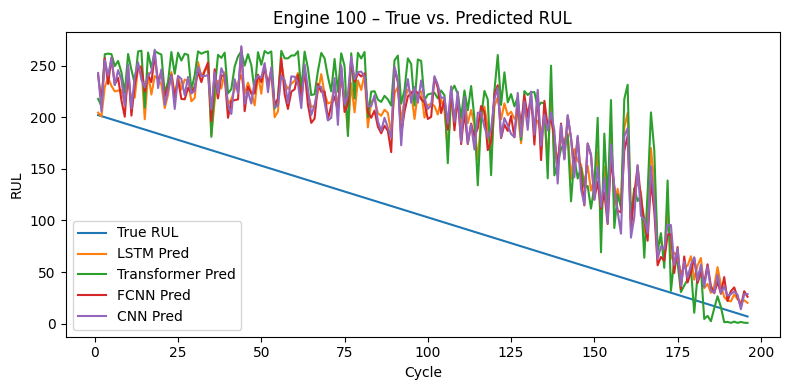

In [46]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]

true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()

## 8.1. Running LSTM using new feature columns

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_corr   = LSTMRegressor(input_dim=len(New_Feature_Cols), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_corr.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_corr, train_loader_corr, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.9048, Val MSE=0.8637
Epoch 2: LSTM Train MSE=0.8190, Val MSE=0.8769
Epoch 3: LSTM Train MSE=0.8019, Val MSE=0.8782
Epoch 4: LSTM Train MSE=0.7916, Val MSE=0.8428
Epoch 5: LSTM Train MSE=0.7823, Val MSE=0.8049
Epoch 6: LSTM Train MSE=0.7730, Val MSE=0.7631
Epoch 7: LSTM Train MSE=0.7644, Val MSE=0.7229
Epoch 8: LSTM Train MSE=0.7586, Val MSE=0.6913
Epoch 9: LSTM Train MSE=0.7565, Val MSE=0.6743
Epoch 10: LSTM Train MSE=0.7539, Val MSE=0.6671
Epoch 11: LSTM Train MSE=0.7525, Val MSE=0.6617
Epoch 12: LSTM Train MSE=0.7513, Val MSE=0.6566
Epoch 13: LSTM Train MSE=0.7503, Val MSE=0.6501
Epoch 14: LSTM Train MSE=0.7490, Val MSE=0.6485
Epoch 15: LSTM Train MSE=0.7483, Val MSE=0.6449
Epoch 16: LSTM Train MSE=0.7474, Val MSE=0.6438
Epoch 17: LSTM Train MSE=0.7467, Val MSE=0.6400
Epoch 18: LSTM Train MSE=0.7460, Val MSE=0.6447
Epoch 19: LSTM Train MSE=0.7459, Val MSE=0.6347
Epoch 20: LSTM Train MSE=0.7450, Val MSE=0.6309
Epoch 21: LSTM Train MSE=0.7442, Val MSE=0.6340
E

## 8.2. Running Transformer using new feature columns

In [20]:
trans_corr   = TransformerRegressor(input_dim=len(New_Feature_Cols), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_corr, train_loader_corr, opt_trans, crit, device)
    val_loss   = eval_model(trans_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=1.0335, Val MSE=0.9023
Epoch 2: Trans Train MSE=0.9815, Val MSE=0.8914
Epoch 3: Trans Train MSE=0.9784, Val MSE=0.9081
Epoch 4: Trans Train MSE=0.9720, Val MSE=0.8356
Epoch 5: Trans Train MSE=0.9977, Val MSE=0.8109
Epoch 6: Trans Train MSE=0.9207, Val MSE=0.7380
Epoch 7: Trans Train MSE=0.8809, Val MSE=0.7044
Epoch 8: Trans Train MSE=0.8582, Val MSE=0.7248
Epoch 9: Trans Train MSE=0.8594, Val MSE=0.7235
Epoch 10: Trans Train MSE=0.8407, Val MSE=0.7229
Epoch 11: Trans Train MSE=0.8347, Val MSE=0.7271
Epoch 12: Trans Train MSE=0.8408, Val MSE=0.7155
Epoch 13: Trans Train MSE=0.8182, Val MSE=0.6963
Epoch 14: Trans Train MSE=0.8194, Val MSE=0.6863
Epoch 15: Trans Train MSE=0.8167, Val MSE=0.6809
Epoch 16: Trans Train MSE=0.8188, Val MSE=0.7004
Epoch 17: Trans Train MSE=0.8132, Val MSE=0.6927
Epoch 18: Trans Train MSE=0.8093, Val MSE=0.6847
Epoch 19: Trans Train MSE=0.8107, Val MSE=0.6916
Epoch 20: Trans Train MSE=0.8061, Val MSE=0.6919
Epoch 21: Trans Train MSE=0.8

## 8.3. Running FCNN using new feature columns

In [21]:
fcnn_corr = FCRegressor(input_dim=len(New_Feature_Cols) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_corr, flat_train_loader_corr, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_corr, flat_val_loader_corr, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.8773, Val MSE=0.7147
Epoch 2: FCNN Train MSE=0.8092, Val MSE=0.7350
Epoch 3: FCNN Train MSE=0.7919, Val MSE=0.6592
Epoch 4: FCNN Train MSE=0.7789, Val MSE=0.6566
Epoch 5: FCNN Train MSE=0.7705, Val MSE=0.6446
Epoch 6: FCNN Train MSE=0.7641, Val MSE=0.6404
Epoch 7: FCNN Train MSE=0.7599, Val MSE=0.6404
Epoch 8: FCNN Train MSE=0.7560, Val MSE=0.6369
Epoch 9: FCNN Train MSE=0.7530, Val MSE=0.6344
Epoch 10: FCNN Train MSE=0.7509, Val MSE=0.6348
Epoch 11: FCNN Train MSE=0.7486, Val MSE=0.6330
Epoch 12: FCNN Train MSE=0.7466, Val MSE=0.6333
Epoch 13: FCNN Train MSE=0.7453, Val MSE=0.6370
Epoch 14: FCNN Train MSE=0.7435, Val MSE=0.6372
Epoch 15: FCNN Train MSE=0.7416, Val MSE=0.6426
Epoch 16: FCNN Train MSE=0.7417, Val MSE=0.6402
Epoch 17: FCNN Train MSE=0.7406, Val MSE=0.6390
Epoch 18: FCNN Train MSE=0.7396, Val MSE=0.6439
Epoch 19: FCNN Train MSE=0.7391, Val MSE=0.6440
Epoch 20: FCNN Train MSE=0.7386, Val MSE=0.6576
Epoch 21: FCNN Train MSE=0.7379, Val MSE=0.6650
E

## 8.4. Running CNN using new feature columns

In [22]:
cnn_model_corr = CNNRegressor(num_features=len(New_Feature_Cols), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_corr.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(1, 101):
    cnn_model_corr.train()
    total_loss = 0
    for xb, yb in train_loader_corr:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_corr(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_corr.dataset)

    # Validation
    cnn_model_corr.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_corr:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_corr(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_corr.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.9205, Val Loss=0.7308
Epoch 2: CNN Train Loss=0.7916, Val Loss=0.7068
Epoch 3: CNN Train Loss=0.7771, Val Loss=0.6977
Epoch 4: CNN Train Loss=0.7701, Val Loss=0.6879
Epoch 5: CNN Train Loss=0.7658, Val Loss=0.6834
Epoch 6: CNN Train Loss=0.7611, Val Loss=0.6814
Epoch 7: CNN Train Loss=0.7575, Val Loss=0.6786
Epoch 8: CNN Train Loss=0.7547, Val Loss=0.6738
Epoch 9: CNN Train Loss=0.7526, Val Loss=0.6723
Epoch 10: CNN Train Loss=0.7510, Val Loss=0.6717
Epoch 11: CNN Train Loss=0.7502, Val Loss=0.6695
Epoch 12: CNN Train Loss=0.7524, Val Loss=0.6751
Epoch 13: CNN Train Loss=0.7515, Val Loss=0.6669
Epoch 14: CNN Train Loss=0.7486, Val Loss=0.6637
Epoch 15: CNN Train Loss=0.7476, Val Loss=0.6613
Epoch 16: CNN Train Loss=0.7476, Val Loss=0.6612
Epoch 17: CNN Train Loss=0.7459, Val Loss=0.6577
Epoch 18: CNN Train Loss=0.7443, Val Loss=0.6571
Epoch 19: CNN Train Loss=0.7446, Val Loss=0.6584
Epoch 20: CNN Train Loss=0.7438, Val Loss=0.6499
Epoch 21: CNN Train Loss=0.74

## 9. Comparing final validation losses for new feature columns

In [23]:
lstm_val  = eval_model(lstm_corr, train_loader_corr, crit, device)
trans_val = eval_model(trans_corr, train_loader_corr, crit, device)
fcnn_val  = eval_model(fcnn_corr, flat_train_loader_corr, crit, device)
cnn_val   = eval_model(cnn_model_corr, train_loader_corr, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.7250, Transformer: 0.7888, FCNN: 0.7778, CNN: 0.7545


## 10. Load test data and run inference for new feature columns

In [24]:
def make_test_sequences_corr(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[New_Feature_Cols].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_corr(x_win).item())
                preds_t.append(trans_corr(x_win).item())
                preds_f.append(fcnn_corr(x_win).item())
                preds_c.append(cnn_model_corr(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

In [25]:
test_seqs_corr = make_test_sequences_corr(test_df_corr, WINDOW_SIZE)


## 11.1. Plot for a chosen engine using new feature columns

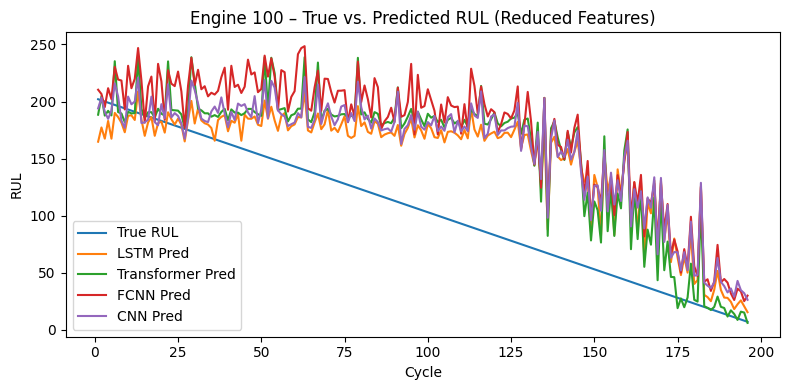

In [26]:
engine_id_corr = list(test_seqs_corr.keys())[99]  # change as desired
seq_corr       = test_seqs_corr[engine_id_corr]


true_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq_corr['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq_corr['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq_corr['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq_corr['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq_corr['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq_corr['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq_corr['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id_corr} – True vs. Predicted RUL (Reduced Features)')
plt.legend()
plt.tight_layout()
plt.show()

## 12. PCA whitening

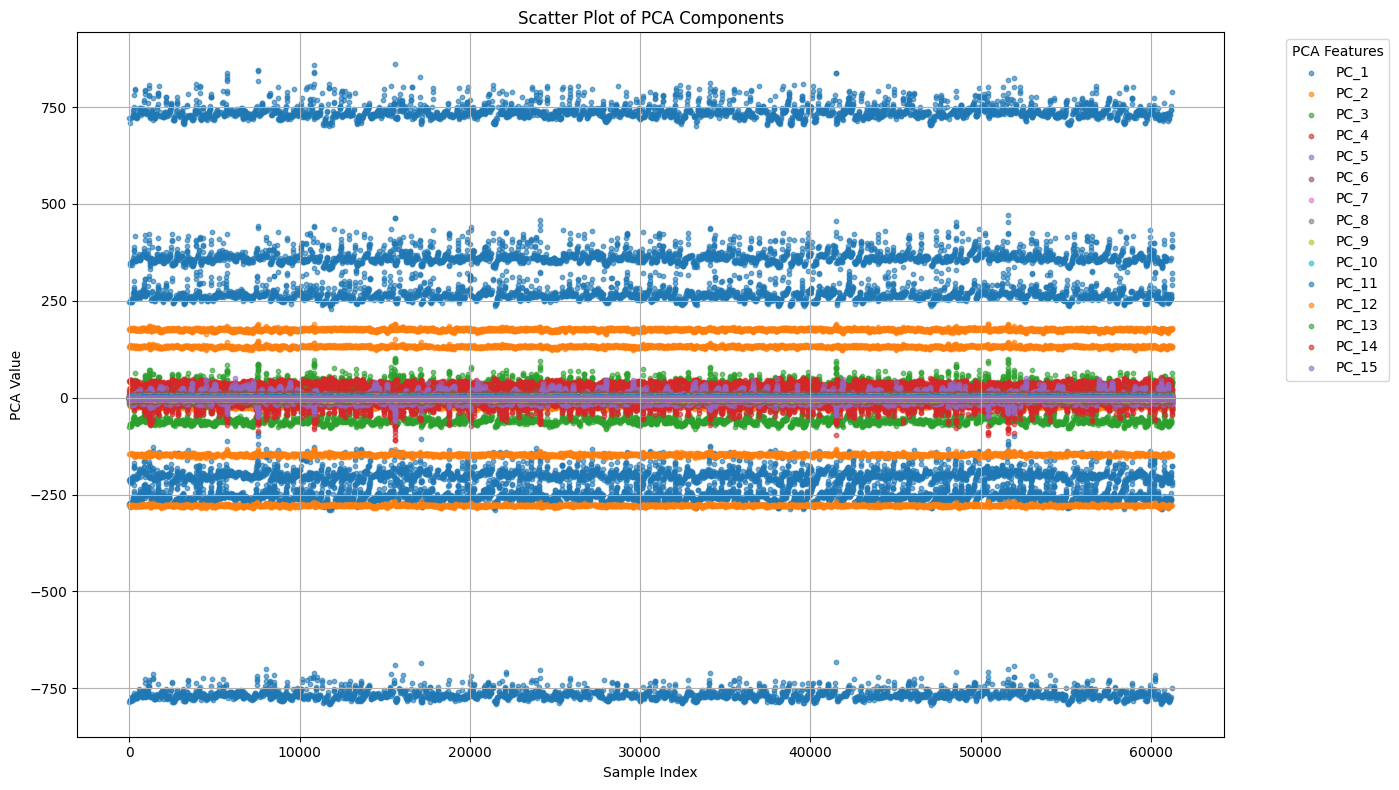

In [27]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% variance
pca = PCA(n_components=15)
pca_features = pca.fit_transform(df[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=feature_cols_pca, index=df.index)

# Optional: downsample if too large
df_pca_plot_sample = df_pca.sample(n=20000, random_state=42) if len(df_pca) > 20000 else df_pca

# Create a scatter plot of all PCA components
plt.figure(figsize=(14, 8))

# Plot each PCA component in a different color
for i, col in enumerate(df_pca.columns):
    plt.scatter(df_pca_plot_sample.index, df_pca_plot_sample[col],
                label=col, s=10, alpha=0.6)

plt.title("Scatter Plot of PCA Components")
plt.xlabel("Sample Index")
plt.ylabel("PCA Value")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), title="PCA Features")
plt.grid(True)
plt.tight_layout()
plt.show()

## 12.1. Create a copy of df for PCA transformation

In [28]:
df_pca_applied = df.copy()

# Drop original feature columns from the copy
df_pca_applied.drop(columns=FEATURE_COLS, inplace=True)

# Add PCA-transformed features to the copy
df_pca_applied = pd.concat([df_pca_applied, df_pca], axis=1)


from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler_pca = StandardScaler()
train_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1, 1)
rul_scaler_pca.fit(train_ruls_pca)

# New column 'RUL_s' for the scaled targets
df_pca_applied['RUL_s'] = df_pca_applied[TARGET_COL].astype(np.float64).values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls_pca)

# Scale val targets (so loss is computed on same scale)
val_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_pca)

print(df_pca_applied.head)

<bound method NDFrame.head of        Engine_ID  Cy_F  Unnamed: 26  RUL        PC_1        PC_2       PC_3  \
0              1     1          NaN  320 -271.985696  176.208555  -2.683544   
1              1     2          NaN  319  247.686492   21.085274 -76.231001   
2              1     3          NaN  318 -275.445860  173.760756  -7.901487   
3              1     4          NaN  317 -270.301028  175.761663   0.068488   
4              1     5          NaN  316 -785.659550 -276.993680 -11.856811   
...          ...   ...          ...  ...         ...         ...        ...   
61244        249   251          NaN    4  423.006044  -22.775633  64.823756   
61245        249   252          NaN    3  798.895381 -153.887982  49.024075   
61246        249   253          NaN    2  810.245303 -154.237726  55.722432   
61247        249   254          NaN    1 -140.465802  134.207741  42.949835   
61248        249   255          NaN    0 -187.237517  177.504731  56.369200   

            PC_4     

## 12.2. PCA-based sequence preparation

In [29]:
def make_sequences_pca(df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[feature_cols_pca].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

## 12.3. Data loader construction for PCA-based time-series sequences

In [30]:
WINDOW_SIZE = 1

train_seqs_pca = make_sequences_pca(df_pca_applied, train_ids, WINDOW_SIZE)
val_seqs_pca   = make_sequences_pca(df_pca_applied, val_ids, WINDOW_SIZE)

train_ds_pca = SequenceDataset(train_seqs_pca)
val_ds_pca   = SequenceDataset(val_seqs_pca)

train_loader_pca = DataLoader(train_ds_pca, batch_size=64, shuffle=False)
val_loader_pca   = DataLoader(val_ds_pca, batch_size=64)

## 12.4. Data loader initialization for flattened PCA-based sequences

In [31]:
flat_train_ds_pca = FlattenedDataset(train_seqs_pca)
flat_val_ds_pca   = FlattenedDataset(val_seqs_pca)

flat_train_loader_pca = DataLoader(flat_train_ds_pca, batch_size=64)
flat_val_loader_pca   = DataLoader(flat_val_ds_pca, batch_size=64)

## 13.1. Running LSTM for PCA-whitened data

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pca   = LSTMRegressor(input_dim=len(feature_cols_pca), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_pca.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_pca, train_loader_pca, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.7163, Val MSE=0.4701
Epoch 2: LSTM Train MSE=0.5879, Val MSE=0.4408
Epoch 3: LSTM Train MSE=0.5493, Val MSE=0.4681
Epoch 4: LSTM Train MSE=0.5346, Val MSE=0.4482
Epoch 5: LSTM Train MSE=0.5306, Val MSE=0.4491
Epoch 6: LSTM Train MSE=0.5250, Val MSE=0.4741
Epoch 7: LSTM Train MSE=0.5222, Val MSE=0.4360
Epoch 8: LSTM Train MSE=0.5141, Val MSE=0.4564
Epoch 9: LSTM Train MSE=0.5104, Val MSE=0.4769
Epoch 10: LSTM Train MSE=0.5070, Val MSE=0.4507
Epoch 11: LSTM Train MSE=0.5015, Val MSE=0.4304
Epoch 12: LSTM Train MSE=0.5041, Val MSE=0.4329
Epoch 13: LSTM Train MSE=0.5025, Val MSE=0.4373
Epoch 14: LSTM Train MSE=0.4973, Val MSE=0.4483
Epoch 15: LSTM Train MSE=0.4916, Val MSE=0.4427
Epoch 16: LSTM Train MSE=0.4909, Val MSE=0.4296
Epoch 17: LSTM Train MSE=0.4904, Val MSE=0.4363
Epoch 18: LSTM Train MSE=0.4904, Val MSE=0.4327
Epoch 19: LSTM Train MSE=0.4910, Val MSE=0.4272
Epoch 20: LSTM Train MSE=0.4895, Val MSE=0.4227
Epoch 21: LSTM Train MSE=0.4904, Val MSE=0.4321
E

## 13.2. Running Transformer for PCA-whitened data

In [33]:
trans_pca   = TransformerRegressor(input_dim=len(feature_cols_pca), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_pca, train_loader_pca, opt_trans, crit, device)
    val_loss   = eval_model(trans_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=1.0255, Val MSE=0.7811
Epoch 2: Trans Train MSE=0.7843, Val MSE=0.7433
Epoch 3: Trans Train MSE=0.7088, Val MSE=0.7709
Epoch 4: Trans Train MSE=0.6781, Val MSE=0.7646
Epoch 5: Trans Train MSE=0.6649, Val MSE=0.8075
Epoch 6: Trans Train MSE=0.6483, Val MSE=0.7576
Epoch 7: Trans Train MSE=0.6376, Val MSE=0.6353
Epoch 8: Trans Train MSE=0.5803, Val MSE=0.6262
Epoch 9: Trans Train MSE=0.5406, Val MSE=0.4980
Epoch 10: Trans Train MSE=0.5235, Val MSE=0.4945
Epoch 11: Trans Train MSE=0.5187, Val MSE=0.4909
Epoch 12: Trans Train MSE=0.5108, Val MSE=0.4826
Epoch 13: Trans Train MSE=0.5096, Val MSE=0.4859
Epoch 14: Trans Train MSE=0.5060, Val MSE=0.4831
Epoch 15: Trans Train MSE=0.5011, Val MSE=0.4825
Epoch 16: Trans Train MSE=0.4993, Val MSE=0.4781
Epoch 17: Trans Train MSE=0.4969, Val MSE=0.4763
Epoch 18: Trans Train MSE=0.4973, Val MSE=0.4792
Epoch 19: Trans Train MSE=0.4960, Val MSE=0.4912
Epoch 20: Trans Train MSE=0.4948, Val MSE=0.4892
Epoch 21: Trans Train MSE=0.4

## 13.3. Running FCNN for PCA-whitened data

In [34]:
fcnn_pca = FCRegressor(input_dim=len(feature_cols_pca) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_pca, flat_train_loader_pca, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_pca, flat_val_loader_pca, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=2.1870, Val MSE=3.4751
Epoch 2: FCNN Train MSE=1.2196, Val MSE=1.5342
Epoch 3: FCNN Train MSE=0.7495, Val MSE=1.2139
Epoch 4: FCNN Train MSE=0.6817, Val MSE=0.8630
Epoch 5: FCNN Train MSE=0.5988, Val MSE=0.4419
Epoch 6: FCNN Train MSE=0.5567, Val MSE=0.4410
Epoch 7: FCNN Train MSE=0.5423, Val MSE=0.4292
Epoch 8: FCNN Train MSE=0.5356, Val MSE=0.4421
Epoch 9: FCNN Train MSE=0.5301, Val MSE=0.4871
Epoch 10: FCNN Train MSE=0.5269, Val MSE=0.4898
Epoch 11: FCNN Train MSE=0.5248, Val MSE=0.4963
Epoch 12: FCNN Train MSE=0.5134, Val MSE=0.5343
Epoch 13: FCNN Train MSE=0.5107, Val MSE=0.5337
Epoch 14: FCNN Train MSE=0.5054, Val MSE=0.5235
Epoch 15: FCNN Train MSE=0.5017, Val MSE=0.5353
Epoch 16: FCNN Train MSE=0.4964, Val MSE=0.5342
Epoch 17: FCNN Train MSE=0.4929, Val MSE=0.5444
Epoch 18: FCNN Train MSE=0.4927, Val MSE=0.5347
Epoch 19: FCNN Train MSE=0.4910, Val MSE=0.5426
Epoch 20: FCNN Train MSE=0.4876, Val MSE=0.5385
Epoch 21: FCNN Train MSE=0.4845, Val MSE=0.5439
E

## 13.4. Running CNN for PCA-whitened data

In [35]:
cnn_model_pca = CNNRegressor(num_features=len(feature_cols_pca), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_pca.parameters(), lr=1e-3, weight_decay=1e-5)


for epoch in range(1, 101):
    cnn_model_pca.train()
    total_loss = 0
    for xb, yb in train_loader_pca:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_pca(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_pca.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_pca:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_pca(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_pca.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.8841, Val Loss=0.9640
Epoch 2: CNN Train Loss=0.6229, Val Loss=0.7063
Epoch 3: CNN Train Loss=0.5467, Val Loss=0.4733
Epoch 4: CNN Train Loss=0.5179, Val Loss=0.4491
Epoch 5: CNN Train Loss=0.5059, Val Loss=0.4607
Epoch 6: CNN Train Loss=0.4995, Val Loss=0.4670
Epoch 7: CNN Train Loss=0.4949, Val Loss=0.4592
Epoch 8: CNN Train Loss=0.4906, Val Loss=0.4548
Epoch 9: CNN Train Loss=0.4844, Val Loss=0.4585
Epoch 10: CNN Train Loss=0.4844, Val Loss=0.4700
Epoch 11: CNN Train Loss=0.4803, Val Loss=0.4515
Epoch 12: CNN Train Loss=0.4781, Val Loss=0.4448
Epoch 13: CNN Train Loss=0.4776, Val Loss=0.4509
Epoch 14: CNN Train Loss=0.4743, Val Loss=0.4499
Epoch 15: CNN Train Loss=0.4744, Val Loss=0.4511
Epoch 16: CNN Train Loss=0.4710, Val Loss=0.4512
Epoch 17: CNN Train Loss=0.4714, Val Loss=0.4772
Epoch 18: CNN Train Loss=0.4708, Val Loss=0.4472
Epoch 19: CNN Train Loss=0.4670, Val Loss=0.4444
Epoch 20: CNN Train Loss=0.4674, Val Loss=0.4470
Epoch 21: CNN Train Loss=0.46

## 14. Comparing final validation losses for PCA-whitened data

In [36]:
lstm_val  = eval_model(lstm_pca, train_loader_pca, crit, device)
trans_val = eval_model(trans_pca, train_loader_pca, crit, device)
fcnn_val  = eval_model(fcnn_pca, flat_train_loader_pca, crit, device)
cnn_val   = eval_model(cnn_model_pca, train_loader_pca, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.4492, Transformer: 0.5066, FCNN: 0.4558, CNN: 0.4802


## 15. Load test data and run interface for PCA-whitened data

In [37]:
import matplotlib.pyplot as plt

test_df_pca   = test_df.copy()

# Apply same scaling
test_df_pca[FEATURE_COLS] = scaler_raw.transform(test_df_pca.loc[:, FEATURE_COLS])
test_df_pca[TARGET_COL_S] = rul_scaler_pca.transform(test_df_pca[[TARGET_COL]])

# Apply PCA to retain 95% variance
pca_features_test = pca.transform(test_df_pca[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features_test.shape[1])]
df_pca_test = pd.DataFrame(pca_features_test, columns=feature_cols_pca, index=test_df_pca.index)
# Create a copy of df for PCA transformation
df_pca_applied_test = test_df_pca.copy()
# Drop original feature columns from the copy
df_pca_applied_test.drop(columns=FEATURE_COLS, inplace=True)
# Add PCA-transformed features to the copy
df_pca_applied_test = pd.concat([df_pca_applied_test, df_pca], axis=1)


def make_test_sequences_pca(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[feature_cols_pca].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_pca(x_win).item())
                preds_t.append(trans_pca(x_win).item())
                preds_f.append(fcnn_pca(x_win).item())
                preds_c.append(cnn_model_pca(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences_pca(df_pca_applied_test, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 16. Plot and save for a chosen engine for PCA-whitened data

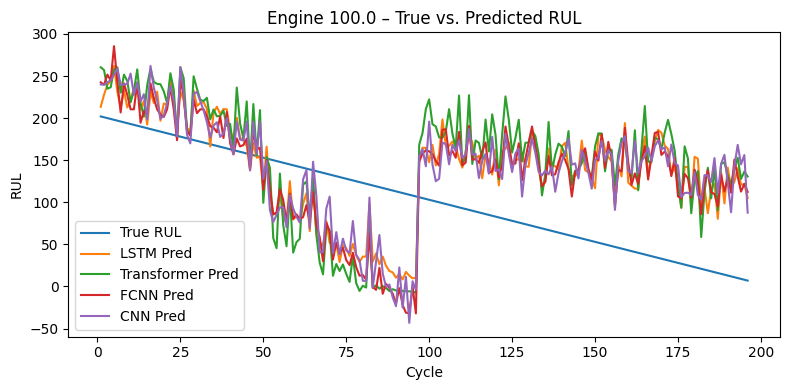

In [38]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()